In [12]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection
from tqdm import tqdm

In [2]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

# Read the data

In [16]:
traces_folder = "split_traces"
labels_folder = "split_labels"

traces_train = None
labels_train = None
traces_val = None
labels_val = None

# Read the training data
for trace in tqdm(os.listdir(f"{traces_folder}/train")):
    voltage = np.loadtxt(f"{traces_folder}/train/{trace}")
    labs = np.loadtxt(f"{labels_folder}/train/{trace}")
    if traces_train is None:
        traces_train = voltage.reshape(1, -1)
        labels_train = np.loadtxt(
            f"{labels_folder}/train/{trace}").reshape(1, -1)
        continue
    else:
        traces_train = np.concatenate([traces_train, voltage.reshape(1, -1)])
        labels_train = np.concatenate([labels_train, labs.reshape(1, -1)])

# Read the validation data
for trace in tqdm(os.listdir(f"{traces_folder}/val")):    
    voltage = np.loadtxt(f"{traces_folder}/val/{trace}")
    labs = np.loadtxt(f"{labels_folder}/val/{trace}")

    if traces_val is None:
        traces_val = voltage.reshape(1, -1)
        labels_val = np.loadtxt(
            f"{labels_folder}/val/{trace}").reshape(1, -1)
        continue
    else:
        traces_val = np.concatenate([traces_val, voltage.reshape(1, -1)])
        labels_val = np.concatenate([labels_val, labs.reshape(1, -1)])

# Convert to numpy arrays
traces_train = np.array(traces_train)
labels_train = np.array(labels_train)
traces_val = np.array(traces_val)
labels_val = np.array(labels_val)

# z-score the traces
traces_train = (traces_train - np.mean(traces_train)) / np.std(traces_train)
traces_val = (traces_val - np.mean(traces_val)) / np.std(traces_val)

# One-hot encode the labels
labels_train = keras.utils.to_categorical(labels_train, num_classes=3)
labels_val = keras.utils.to_categorical(labels_val, num_classes=3)


  0%|          | 0/811 [00:00<?, ?it/s]


ValueError: zero-dimensional arrays cannot be concatenated

In [15]:
traces_train.shape

(0, 1000)

# Model

We create a 1D UNet model to analyse our data.

In [18]:
 # We expect 1000 samples per trace
input_layer = keras.Input(shape=(1000, 1), name= "Input")
# 3 layers of convolution and pooling (encoder)
first_conv = layers.Conv1D(
    filters=32, kernel_size=11, padding="same", activation="relu", name="Conv_1")(input_layer)
first_pool = layers.MaxPooling1D(
    pool_size=2, name="Max_Pool_1")(first_conv)
second_conv = layers.Conv1D(
    filters=64, kernel_size=11, padding="same", activation="relu", name="Conv_2")(first_pool)
second_pool = layers.MaxPooling1D(
    pool_size=2, name="Max_Pool_2")(second_conv)
third_conv = layers.Conv1D(
    filters=128, kernel_size=11, padding="same", activation="relu", name="Conv_3")(second_pool)
third_pool = layers.MaxPooling1D(
    pool_size=2, name="Max_Pool_3")(third_conv)
# Latent space
latent = layers.Conv1D(
    filters=256, kernel_size=11, padding="same", activation="relu", name="Conv_4")(third_pool)
fourth_up = layers.UpSampling1D(size=2, name="Up_Sample_1")(latent)
fifth_conv = layers.Conv1D(
    filters=128, kernel_size=11, padding="same", activation="relu", name="Conv_5")(fourth_up)
fifth_conv = layers.concatenate([fifth_conv, third_conv])    
fifth_up = layers.UpSampling1D(size=2, name="Up_Sample_2")(fifth_conv)
sixth_conv = layers.Conv1D(
    filters=64, kernel_size=11, padding="same", activation="relu", name="Conv_6")(fifth_up)
sixth_conv = layers.concatenate([sixth_conv, second_conv])
sixth_up = layers.UpSampling1D(size=2, name="Up_Sample_3")(sixth_conv)

final_conv = layers.Conv1D(
    filters=32, kernel_size=11, padding="same", activation="relu", name="Conv_7")(sixth_up)
final_conv = layers.concatenate([final_conv, first_conv])

# Output layer - 1x1 convolution with softmax activation to get a probability for each class
output = layers.Conv1D(
    filters=3, kernel_size=1, padding="same", activation="softmax", name="Output")(final_conv)

model = keras.Model(inputs=input_layer, outputs=output)

# plot the model
keras.utils.plot_model(model, show_shapes=True)

# Metrics to track during training
def IoU(y_true, y_pred, eps=1e-6):
    """
    Compute Intersection over Union (IoU) metric for two tensors.
    Args:
        y_true: true labels tensor.
        y_pred: predicted labels tensor.
        eps: optional epsilon value to avoid division by zero.
    Returns:
        IoU score.
    """
    # Compute intersections and union
    intersections = tf.reduce_sum(y_true * y_pred)
    unions = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersections + eps
    return intersections / unions
    
def Dice(y_true, y_pred, eps=1e-6):
    """
    Compute Dice coefficient metric for two tensors.
    Args:
        y_true: true labels tensor.
        y_pred: predicted labels tensor.
        eps: optional epsilon value to avoid division by zero.
    Returns:
        Dice score.
    """
    # Compute intersections and sums
    intersections = tf.reduce_sum(y_true * y_pred)
    sums = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + eps
    return (2.0 * intersections) / sums

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[IoU, Dice]
)

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 1000, 1)]    0           []                               
                                                                                                  
 Conv_1 (Conv1D)                (None, 1000, 32)     384         ['Input[0][0]']                  
                                                                                                  
 Max_Pool_1 (MaxPooling1D)      (None, 500, 32)      0           ['Conv_1[0][0]']                 
                                                                                                  
 Conv_2 (Conv1D)                (None, 500, 64)      22592       ['Max_Pool_1[0][0]']             
                                                                                            

# Training

In [20]:
history = model.fit(
    x=traces_train,
    y=labels_train,
    batch_size=128,
    epochs=50,
    validation_data=(traces_val, labels_val)
)

Epoch 1/50
6/6 [==============================] - 9s 752ms/step - loss: 1.0476 - IoU: 0.2389 - Dice: 0.3849 - val_loss: 0.9458 - val_IoU: 0.2268 - val_Dice: 0.3671
Epoch 2/50
6/6 [==============================] - 4s 657ms/step - loss: 0.9650 - IoU: 0.2620 - Dice: 0.4147 - val_loss: 0.9408 - val_IoU: 0.2337 - val_Dice: 0.3762
Epoch 3/50
6/6 [==============================] - 4s 650ms/step - loss: 0.9549 - IoU: 0.2555 - Dice: 0.4059 - val_loss: 0.9354 - val_IoU: 0.2365 - val_Dice: 0.3810
Epoch 4/50
6/6 [==============================] - 4s 685ms/step - loss: 0.9628 - IoU: 0.2513 - Dice: 0.4016 - val_loss: 0.9187 - val_IoU: 0.2423 - val_Dice: 0.3886
Epoch 5/50
6/6 [==============================] - 4s 739ms/step - loss: 0.9491 - IoU: 0.2685 - Dice: 0.4230 - val_loss: 0.9080 - val_IoU: 0.2530 - val_Dice: 0.4013
Epoch 6/50
6/6 [==============================] - 4s 672ms/step - loss: 0.9369 - IoU: 0.2753 - Dice: 0.4315 - val_loss: 0.9131 - val_IoU: 0.2466 - val_Dice: 0.3935
Epoch 7/50
6/6 [

## Results

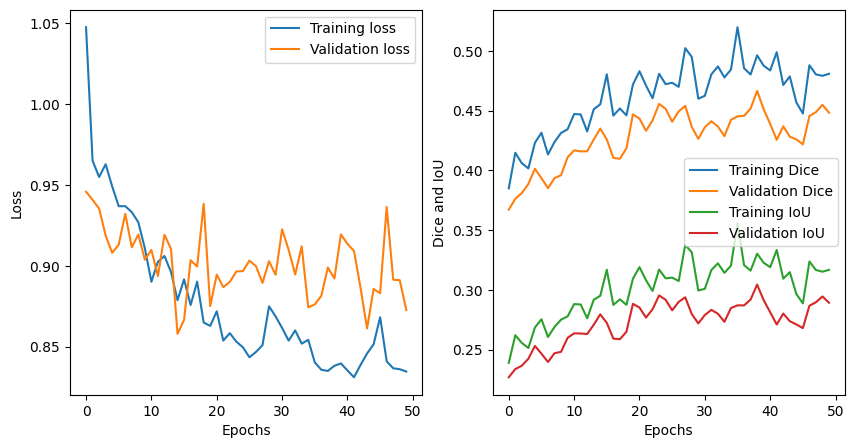

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(history.history["loss"], label="Training loss")
ax[0].plot(history.history["val_loss"], label="Validation loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

# Plot Dice and IoU
ax[1].plot(history.history["Dice"], label="Training Dice")
ax[1].plot(history.history["val_Dice"], label="Validation Dice")
ax[1].plot(history.history["IoU"], label="Training IoU")
ax[1].plot(history.history["val_IoU"], label="Validation IoU")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Dice and IoU")
ax[1].legend()

plt.show()

Plot a few examples of the training data and the predicted masks.

1/1 [==============================] - 0s 38ms/step


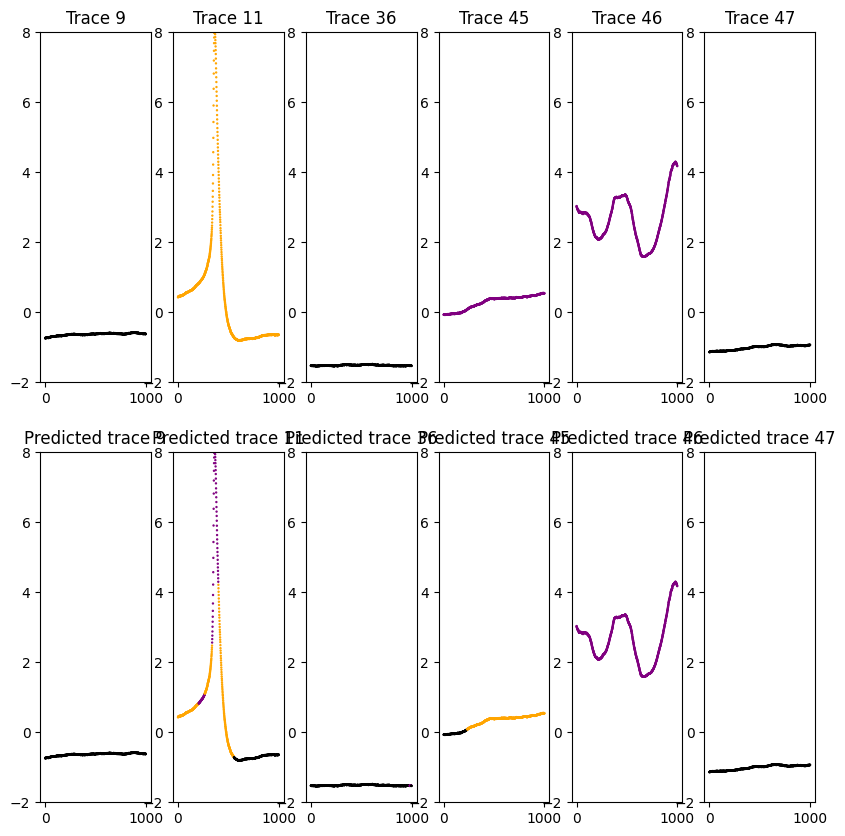

In [24]:
trace_ids = [9, 11, 36, 45, 46, 47]
cols = ["black", "orange", "purple"]

fig, ax = plt.subplots(2, len(trace_ids), figsize=(10, 10))

for i, trace in enumerate(trace_ids):
    # Plot the original trace
    c = [cols[j] for j in np.argmax(labels_val[trace], axis=1)]
    ax[0, i].scatter(range(len(traces_val[trace])), traces_val[trace], c=c, s=0.5)
    ax[0, i].set_ylim(-2, 8)
    ax[0, i].set_title(f"Trace {trace}")

    pred = model.predict(traces_val[trace].reshape(1, 1000, 1))
    c = [cols[j] for j in np.argmax(pred, axis=2)[0]]
    ax[1, i].scatter(range(len(traces_val[trace])), traces_val[trace], c=c, s=0.5)
    ax[1, i].set_ylim(-2, 8)
    ax[1, i].set_title(f"Predicted trace {trace}")


plt.show()
